##### Dataset info:

Customer churn dataset containing real records from a leading Bulgarian telecom operator, specifically for business customers, including small, medium, and large companies.

##### Feature Dictionary:

| Feature name               | Description                                                                                       |
|----------------------------|---------------------------------------------------------------------------------------------------|
| `PID`                      | Personal identification number of the business customer.                                         |
| `CRM PID Value Segment`    | Segment indicating the value of the customer to the telecom company.                             |
| `Billing ZIP`              | ZIP code (city / village) where the company is located.                                          |
| `KA name`                  | Name of the Key Account Manager serving the customer.                                            |
| `Active subscribers`       | Number of active subscribers for this PID.                                                       |
| `Not Active subscribers`   | Number of non-active subscribers for this PID.                                                   |
| `Suspended subscribers`    | Number of suspended subscribers in the last 6 months.                                            |
| `Total Subscribers`        | Total number of subscribers for the business customer.                                           |
| `Average Mobile Revenue`   | Average subscriber revenue from mobile services.                                                 |
| `Average Fix Revenue`      | Average subscriber revenue for fixed services (phone lines and fixed internet access).           |
| `Total Revenue`            | Total revenue from the business customer.                                                        |
| `ARPU`                     | Average revenue per user/subscriber.                                                             |
| `Churn`                    | Whether the customer churned to another telecom (`Yes` / `No`).                                  |

##### Dataset Source:

https://data.mendeley.com/datasets/nrb55gr66h/1

In [27]:
# section 1: environment setup

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 100)

In [28]:
# section 2: data loading

data_path = "../data/raw/telecom_churn_dataset.csv"
df = pd.read_csv(data_path)

df.head()

,PID,CRM_PID_Value_Segment,EffectiveSegment,Billing_ZIP,KA_name,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,AvgMobileRevenue,AvgFIXRevenue,TotalRevenue,ARPU,CHURN
0,123759242,Bronze,SOHO,6000.0,VM,2,NaN,NaN,2,40.17,0.0,40.17,NaN,No
1,126145737,Bronze,SOHO,6400.0,VM,3,NaN,NaN,3,40.17,0.0,40.17,13.39,No
2,123506355,Bronze,SOHO,6000.0,DI,2,3.0,NaN,5,40.17,0.0,40.17,20.09,No
3,112595585,Bronze,SOHO,4400.0,MT,1,2.0,NaN,3,40.17,0.0,40.17,40.17,No
4,115097935,Iron,SOHO,4000.0,AD,2,1.0,NaN,3,40.17,0.0,40.17,20.09,No


In [29]:
df.dtypes

PID                        object
CRM_PID_Value_Segment      object
EffectiveSegment           object
Billing_ZIP               float64
KA_name                    object
Active_subscribers          int64
Not_Active_subscribers    float64
Suspended_subscribers     float64
Total_SUBs                  int64
AvgMobileRevenue          float64
AvgFIXRevenue             float64
TotalRevenue              float64
ARPU                      float64
CHURN                      object
dtype: object

In [30]:
df.isna().mean().sort_values(ascending=False).head(20)

Suspended_subscribers     0.958358
Not_Active_subscribers    0.490832
CRM_PID_Value_Segment     0.000592
Billing_ZIP               0.000237
ARPU                      0.000118
PID                       0.000000
EffectiveSegment          0.000000
KA_name                   0.000000
Active_subscribers        0.000000
Total_SUBs                0.000000
AvgMobileRevenue          0.000000
AvgFIXRevenue             0.000000
TotalRevenue              0.000000
CHURN                     0.000000
dtype: float64

Check for missing values in the dataset

In [31]:
# a hepler to find and report the missing values:

def report_missing_values(df, sort_desc=True, min_pct=0.0):
    """
    Print and return a summary of missing values per column.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    sort_desc : bool, default=True
        If True, sort columns by % of missing values (highest first).
    min_pct : float, default=0.0
        Minimum percentage threshold (0–100). Only columns with
        pct_missing >= min_pct will be shown.
    
    Returns
    -------
    missing_df : pd.DataFrame
        DataFrame with columns:
        - n_missing
        - pct_missing
    """
    n_rows = len(df)
    missing_count = df.isna().sum()
    missing_pct = df.isna().mean() * 100  # percentage
    
    # Keep only columns with at least one NaN
    mask_has_missing = missing_count > 0
    missing_count = missing_count[mask_has_missing]
    missing_pct = missing_pct[mask_has_missing]
    
    # Apply minimum percentage filter
    mask_above_threshold = missing_pct >= min_pct
    missing_count = missing_count[mask_above_threshold]
    missing_pct = missing_pct[mask_above_threshold]
    
    # Build result DataFrame
    missing_df = pd.DataFrame({
        "n_missing": missing_count,
        "pct_missing": missing_pct.round(2)
    })
    
    if sort_desc:
        missing_df = missing_df.sort_values("pct_missing", ascending=False)
    
    # Print summary
    print("\n[Missing Values Report]")
    print(f"Total rows: {n_rows}")
    print(f"Columns with missing values (>= {min_pct:.1f}%): {missing_df.shape[0]}")
    
    if missing_df.empty:
        print("No columns with missing values 👍")
    else:
        print("\nColumns with missing values:")
        for col, row in missing_df.iterrows():
            print(f"  - {col}: {int(row['n_missing'])} missing "
                  f"({row['pct_missing']:.2f}% of rows)")
    
    print("-" * 50)
    return missing_df


In [32]:
missing_summary = report_missing_values(df)


[Missing Values Report]
Total rows: 8453
Columns with missing values (>= 0.0%): 5

Columns with missing values:
  - Suspended_subscribers: 8101 missing (95.84% of rows)
  - Not_Active_subscribers: 4149 missing (49.08% of rows)
  - CRM_PID_Value_Segment: 5 missing (0.06% of rows)
  - Billing_ZIP: 2 missing (0.02% of rows)
  - ARPU: 1 missing (0.01% of rows)
--------------------------------------------------


Features to exclude completely since they cannot be imputed: Suspended_subscribers, Not_Active_subscribers

Missing values from other features will be decided based on the feature importance

In [33]:
# get a read copy of our target
target = df["CHURN"]

In [34]:
target.value_counts(dropna=False)

CHURN
No     7904
Yes     549
Name: count, dtype: int64

In [35]:
target.value_counts(normalize=True) * 100

CHURN
No     93.505264
Yes     6.494736
Name: proportion, dtype: float64

Imbalanced dataset

In [36]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [37]:
num_cols, cat_cols

(['Billing_ZIP',
  'Active_subscribers',
  'Not_Active_subscribers',
  'Suspended_subscribers',
  'Total_SUBs',
  'AvgMobileRevenue ',
  'AvgFIXRevenue',
  'TotalRevenue',
  'ARPU'],
 ['PID', 'CRM_PID_Value_Segment', 'EffectiveSegment', 'KA_name', 'CHURN'])

In [38]:
# churn vs. key features (testing only)

df.groupby("EffectiveSegment")['CHURN'].value_counts(normalize=True).unstack()

CHURN,No,Yes
EffectiveSegment,,
LE,1.000000,NaN
Other,0.931034,0.068966
SE,0.976190,0.023810
SME,0.911972,0.088028
SOHO,0.942549,0.057451
VSE,0.911421,0.088579


In [39]:
# Dataset Cleanup: remove NaNs from target:
# drop rows where churn (target) is missing
print(f"Dataset shape before removing NaNs from the target: {df.shape}")
# count the NaNs in the target before removal
target_nans = df["CHURN"].isna().sum()
print(f"Num. of NaNs in target: {target_nans}")
# drop NaNs from target
df = df.dropna(subset=["CHURN"])
print(f"Dataset shape after removing NaNs from the target: {df.shape}")

Dataset shape before removing NaNs from the target: (8453, 14)
Num. of NaNs in target: 0
Dataset shape after removing NaNs from the target: (8453, 14)


In [40]:
# decode churn feature
df["churn_flag"] = df["CHURN"].map({"Yes": 1, "No": 0})

Simple charts to understand the target

Questions to answer:

- Is the target imbalanced?
- Rough sense of how many churners we have?

C:\Users\malik\AppData\Local\Temp\ipykernel_8996\2260850075.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


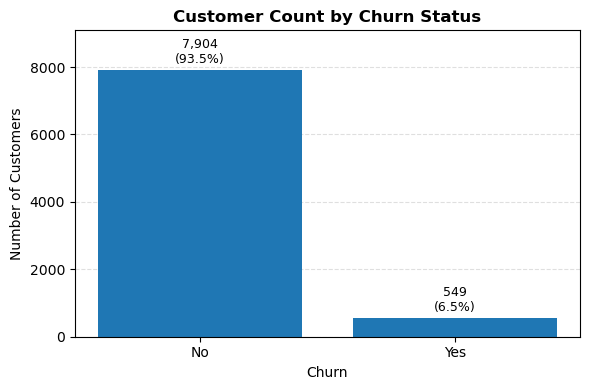

In [41]:
churn_counts = df["CHURN"].value_counts().sort_index()
churn_pct = churn_counts / churn_counts.sum() * 100

fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(churn_counts.index.astype(str), churn_counts.values)

ax.set_title("Customer Count by Churn Status", fontsize=12, fontweight="bold")
ax.set_xlabel("Churn", fontsize=10)
ax.set_ylabel("Number of Customers", fontsize=10)
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_axisbelow(True)

# some space on top so labels don’t go out of bounds
ax.set_ylim(0, churn_counts.max() * 1.15)   # 15% headroom

labels = [f"{c:,}\n({p:.1f}%)" for c, p in zip(churn_counts, churn_pct)]
ax.bar_label(bars, labels=labels, padding=3, fontsize=9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

**Business question**  
How is churn distributed across the different customer segments, and which segments are driving most of the churn?

**Why this step?**  
The `EffectiveSegment` variable represents how the business classifies customers (e.g. SOHO, VSE, SME, etc.). If churn is concentrated in specific segments, this has two impacts:
- Business: those segments become priority targets for retention actions.
- Modeling: `EffectiveSegment` is likely an important predictor and should be kept in the churn model.

**What this cell does**  
- Builds a **crosstab** between `EffectiveSegment` and `CHURN` to count customers in each (segment, churn) combination.  
- Computes the **total number of customers per segment** and the **churn rate** within each segment.  
- Plots a **stacked bar chart**:
  - Bars = segments  
  - Each bar is split into “No” vs “Yes” churn counts  

**Expected insight**  
- Identify which segments are **largest by customer count** (volume).  
- See which segments have **higher churn rates**, even if their volume is small.  
- Spot segments that are both **large and high-churn** → these are high-impact targets for business interventions and key features to monitor in the model.

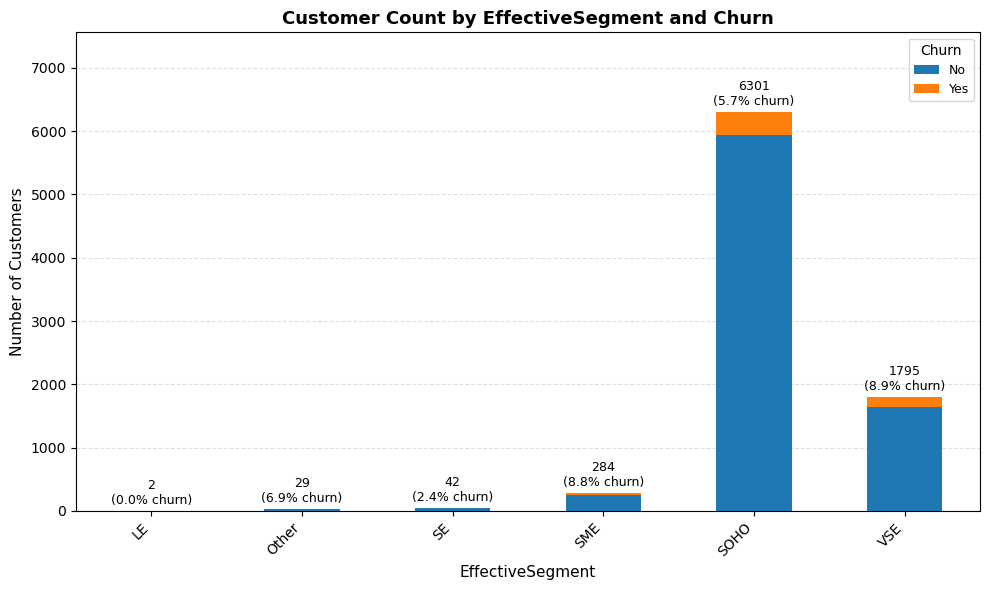

In [42]:
segment_col = "EffectiveSegment"

# Crosstab: segment vs churn
ct_counts = pd.crosstab(df[segment_col], df["CHURN"])

# Totals per segment
totals = ct_counts.sum(axis=1)

# Try to detect the "churn = Yes" column name robustly
yes_col_candidates = [c for c in ct_counts.columns if str(c).lower() in ("yes", "1", "true")]
if len(yes_col_candidates) != 1:
    raise ValueError(f"Cannot identify churn-positive column in {ct_counts.columns}")
yes_col = yes_col_candidates[0]

churn_rate = (ct_counts[yes_col] / totals) * 100  # churn % per segment

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar plot
ct_counts.plot(kind="bar", stacked=True, ax=ax)

ax.set_title(f"Customer Count by {segment_col} and Churn", fontsize=13, fontweight="bold")
ax.set_xlabel(segment_col, fontsize=11)
ax.set_ylabel("Number of Customers", fontsize=11)
ax.set_xticklabels(ct_counts.index, rotation=45, ha="right")

ax.yaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
ax.legend(title="Churn", fontsize=9, title_fontsize=10)

# Add some headroom for labels
ax.set_ylim(0, totals.max() * 1.20)

# ONE clean label per segment: "N (x.x% churn)" above the bar
for i, (total, rate) in enumerate(zip(totals, churn_rate)):
    ax.text(
        i,
        total + totals.max() * 0.01,          # just above bar
        f"{int(total)}\n({rate:.1f}% churn)", # e.g. "6301\n(5.7% churn)"
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

### Check cardinality of categorical features

**Why this step?**  
Before choosing an encoding strategy, we need to understand how many distinct categories each categorical feature has. Very high-cardinality features (many unique values) may be poor candidates for one-hot encoding and might need alternative treatment or exclusion.

**What this cell does**  
- Loops over all categorical columns in `cat_cols`.  
- Reports the number and percentage of unique values for each feature.  
- Highlights high-cardinality features and shows example categories.

**How we’ll use it**  
This summary will guide which categorical features we keep and one-hot encode, and which ones are too granular or noisy and should be excluded or handled differently.

In [43]:
def report_categorical_cardinality(df, cat_cols, high_cardinality_threshold=50, max_example_categories=5):
    """
    Report cardinality (number of unique categories) for each categorical feature.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    cat_cols : list of str
        List of categorical column names to analyze.
    high_cardinality_threshold : int, default=50
        Columns with n_unique > this value will be flagged as high-cardinality.
    max_example_categories : int, default=5
        Number of example categories to print for each column.
        
    Returns
    -------
    summary_df : pd.DataFrame
        DataFrame with:
        - n_unique : number of distinct non-null categories
        - pct_unique : percentage of unique categories relative to number of rows
    """
    n_rows = len(df)
    
    records = []
    for col in cat_cols:
        if col not in df.columns:
            print(f"[WARN] Column '{col}' not in dataframe, skipping.")
            continue
        
        n_unique = df[col].nunique(dropna=True)
        pct_unique = (n_unique / n_rows * 100) if n_rows > 0 else 0.0
        
        records.append({
            "column": col,
            "n_unique": n_unique,
            "pct_unique": round(pct_unique, 2),
        })
    
    summary_df = pd.DataFrame(records).set_index("column")
    summary_df = summary_df.sort_values("n_unique", ascending=False)
    
    # --- Printing section ---
    print("\n[Categorical Cardinality Report]")
    print(f"Total rows: {n_rows}")
    print(f"Categorical columns analyzed: {len(summary_df)}")
    
    # High-cardinality columns
    high_card_cols = summary_df[summary_df["n_unique"] > high_cardinality_threshold]
    if not high_card_cols.empty:
        print(f"\nColumns with HIGH cardinality (n_unique > {high_cardinality_threshold}):")
        for col, row in high_card_cols.iterrows():
            print(f"  - {col}: {row['n_unique']} unique values "
                  f"({row['pct_unique']:.2f}% of rows)")
    else:
        print(f"\nNo columns above high-cardinality threshold (> {high_cardinality_threshold} uniques).")
    
    # Per-column examples
    print("\nPer-column details (sorted by n_unique):")
    for col, row in summary_df.iterrows():
        n_unique = int(row["n_unique"])
        pct_unique = row["pct_unique"]
        
        print(f"\n- {col}")
        print(f"  Unique categories: {n_unique} ({pct_unique:.2f}% of rows)")
        
        # Example categories (top most frequent)
        value_counts = df[col].value_counts(dropna=True)
        top_examples = value_counts.head(max_example_categories)
        
        print("  Top categories:")
        for idx, (cat, count) in enumerate(top_examples.items(), start=1):
            pct = count / n_rows * 100 if n_rows > 0 else 0
            print(f"    {idx}. {repr(cat)}: {count} ({pct:.2f}% of rows)")
    
    print("-" * 60)
    return summary_df

In [44]:
report_categorical_cardinality(df, cat_cols = cat_cols)


[Categorical Cardinality Report]
Total rows: 8453
Categorical columns analyzed: 5

Columns with HIGH cardinality (n_unique > 50):
  - PID: 8436.0 unique values (99.80% of rows)

Per-column details (sorted by n_unique):

- PID
  Unique categories: 8436 (99.80% of rows)
  Top categories:
    1. '2.02E+12': 5 (0.06% of rows)
    2. '1.29E+12': 5 (0.06% of rows)
    3. '1.22E+12': 4 (0.05% of rows)
    4. '1.21E+12': 4 (0.05% of rows)
    5. '8.32E+12': 3 (0.04% of rows)

- KA_name
  Unique categories: 12 (0.14% of rows)
  Top categories:
    1. 'VM': 769 (9.10% of rows)
    2. 'RJ': 751 (8.88% of rows)
    3. 'Tatiana Trifonova': 719 (8.51% of rows)
    4. 'Ginka Vachkova': 715 (8.46% of rows)
    5. 'Jenia Gogova': 714 (8.45% of rows)

- CRM_PID_Value_Segment
  Unique categories: 9 (0.11% of rows)
  Top categories:
    1. 'Bronze': 3820 (45.19% of rows)
    2. 'Silver': 2039 (24.12% of rows)
    3. 'Gold': 1453 (17.19% of rows)
    4. 'Platinum': 537 (6.35% of rows)
    5. 'SME': 284 (3

,n_unique,pct_unique
column,,
PID,8436,99.80
KA_name,12,0.14
CRM_PID_Value_Segment,9,0.11
EffectiveSegment,6,0.07
CHURN,2,0.02


#### EDA Finding – Redundant `Total Revenue` Feature

**Finding**  
During EDA we confirmed that `Total Revenue` is essentially the sum of `Average Mobile Revenue` and `Average Fix Revenue` for each customer. This means `Total Revenue` is a linear combination of existing features and does not add new information on its own.

**Decision**  
- Use `Total Revenue` **only for feature engineering**, to compute revenue mix per customer:  
  - `mobile_share = Average Mobile Revenue / Total Revenue`  
  - `fixed_share  = Average Fix Revenue   / Total Revenue`  
- After creating these features, **exclude `Total Revenue` from the modeling feature set**.

**Rationale**  
We keep the signal about how revenue is split between mobile and fixed services, while avoiding redundant features that would just duplicate information and make the feature space noisier.


### EDA Output – Modeling Decisions Summary

This section summarizes the concrete decisions coming out of the EDA.  
All implementations will be done in the **data prep & modeling** notebook based on the rules below.

---

#### 1. Features to exclude from modeling

- `PID`  
  - Reason: High-cardinality identifier; no business signal, mainly for joins/traceability.

- `Suspended_subscribers`  
  - Reason: ~96% missing; cannot be reliably imputed and would mostly add noise.

- `Not_Active_subscribers`  
  - Reason: ~50% missing; no robust imputation strategy and limited added value vs other subscriber counts.

- `Billing_ZIP`  
  - Reason: Location information will be **excluded initially** to keep the first version of the model simpler.  
    Can be reconsidered later (e.g. region-level features) if needed.

These columns will be dropped in the data prep step before model training.

---

#### 2. Missing values – row-level exclusion

- `CRM_PID_Value_Segment`: 5 records with missing values.  
- `ARPU`: 1 record with a missing value.

**Decision:**  
- Drop these **6 rows** from the dataset (small fraction of total customers, and values are essential for segmentation and revenue behavior).  
- All remaining rows must have non-missing values in `CRM_PID_Value_Segment` and `ARPU`.

---

#### 3. Feature engineering

- **Revenue mix per customer**
  - Use `Average Mobile Revenue`, `Average Fix Revenue`, and `Total Revenue` to create:
    - `mobile_share = Average Mobile Revenue / Total Revenue`
    - `fixed_share  = Average Fix Revenue / Total Revenue`
  - After creating these features, `Total Revenue` will be excluded from the modeling feature set (kept only for reporting/EDA if needed).

---

#### 4. Encoding strategy (initial)

- One-hot encoding for categorical features:
  - `KA_name`
  - `CRM_PID_Value_Segment`
  - `EffectiveSegment`

- Target encoding for churn label:
  - `Churn` will be mapped manually to a binary variable (e.g. `0 = No`, `1 = Yes`)  
    rather than one-hot encoding, since it is the target variable.

These encoding rules will be implemented in the data prep & modeling notebook and later migrated into Python scripts for a production-like pipeline.
